In [1]:
import ohsome
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import rasterio
from osgeo import gdal
import shapely.wkt
from shapely.geometry import box, Polygon, MultiPolygon
import utm
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
import xarray as xr
import numpy as np
import warnings
from tqdm.notebook import tqdm
import json
import os
import yaml

Define constants.

In [2]:
DATA_PATH = "C:/Users/Tim/.keras/datasets/greenspace_transfer/"
RADIUS = 5000

Load data about cities, drop NAs and cities with less than 200.000 inhabitants (only major cities).

In [3]:
cities_df = pd.read_csv(DATA_PATH+"density/worldcities.csv")
cities_df.dropna(subset=["city", "lat", "lng", "population"], inplace=True)
cities_df = cities_df[cities_df["population"] > 200000]
print(cities_df.shape)
cities_df.head()

(2743, 11)


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,primary,39105000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,35362000.0,1360771077
2,Delhi,Delhi,28.6667,77.2167,India,IN,IND,Delhi,admin,31870000.0,1356872604
3,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23971000.0,1608618140
4,São Paulo,Sao Paulo,-23.5504,-46.6339,Brazil,BR,BRA,São Paulo,admin,22495000.0,1076532519


In [4]:
# cities_df = cities_df.iloc[:10,:].copy()
cities_df.loc[:, "radius"] = RADIUS
cities_df.loc[:, "density"] = 0.0
cities_df.shape

(2743, 13)

In [5]:
client = ohsome.OhsomeClient()

Find out density in terms of the number of OSM objects inside a circle with radius 5km around the the city center per square kilometer.

In [110]:
retries = 10
for i in range(retries):
    try:
        for index, row in tqdm(cities_df.iterrows(), total=cities_df.shape[0]):
            if cities_df.loc[index, "density"] == 0.0:
                query = {row["city"]: [row["lng"], row["lat"], row["radius"]]}
                response = client.elements.count.density.post(bcircles=query)
                cities_df.loc[index, "density"] = response.as_dataframe().iloc[0,0]
            else:
                pass
        break
    except:
        pass

In [6]:
# cities_df.to_csv(DATA_PATH+"density/worldcities_density.csv", index=False)
cities_df = pd.read_csv(DATA_PATH+"density/worldcities_density.csv")
cities_df.sort_values(by=["density"], ascending=False).head(20)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,radius,density
34,Paris,Paris,48.8566,2.3522,France,FR,FRA,Île-de-France,primary,11027000.0,1250015082,5000,8072.05
708,Amsterdam,Amsterdam,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,1528355309,5000,7960.18
276,Taichung,Taichung,24.1500,120.6667,Taiwan,TW,TWN,Taichung,admin,2803894.0,1158689622,5000,7693.32
732,The Hague,The Hague,52.0800,4.3100,Netherlands,NL,NLD,Zuid-Holland,primary,537833.0,1528799905,5000,6514.89
2058,Strasbourg,Strasbourg,48.5833,7.7458,France,FR,FRA,Grand Est,admin,284677.0,1250789140,5000,6355.36
1085,Rotterdam,Rotterdam,51.9225,4.4792,Netherlands,NL,NLD,Zuid-Holland,minor,631155.0,1528892850,5000,5841.76
2377,Lille,Lille,50.6278,3.0583,France,FR,FRA,Hauts-de-France,admin,233098.0,1250071961,5000,5296.97
1358,Edinburgh,Edinburgh,55.9530,-3.1890,United Kingdom,GB,GBR,"Edinburgh, City of",NaN,488050.0,1826492520,5000,5228.67
1756,Utrecht,Utrecht,52.0889,5.1156,Netherlands,NL,NLD,Utrecht,admin,343779.0,1528871692,5000,4958.62
1629,London,London,42.9836,-81.2497,Canada,CA,CAN,Ontario,NaN,383822.0,1124469960,5000,4952.28


In [7]:
cities_df.sort_values(by=["density"], ascending=True).head(20)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,radius,density
777,Natal,Natal,-6.9838,-60.2699,Brazil,BR,BRA,Amazonas,NaN,980588.0,1076336975,5000,0.15
2470,Noginsk,Noginsk,64.4833,91.2333,Russia,RU,RUS,Krasnoyarskiy Kray,NaN,229731.0,1643129651,5000,0.17
1707,Cubal,Cubal,-13.1117,14.3672,Angola,AO,AGO,Benguela,NaN,357618.0,1024580158,5000,0.20
2351,Sapele,Sapele,5.8261,5.6536,Nigeria,NG,NGA,Delta,minor,242652.0,1566310893,5000,0.41
796,Anqiu,Anqiu,36.3619,119.1072,China,CN,CHN,Shandong,NaN,947723.0,1156592047,5000,0.70
1143,Al Ḩillah,Al Hillah,23.4895,46.7564,Saudi Arabia,SA,SAU,Ar Riyāḑ,NaN,594605.0,1682494753,5000,0.79
589,Guankou,Guankou,28.2363,113.6984,China,CN,CHN,Hunan,minor,1168056.0,1156249346,5000,0.87
300,Longba,Longba,33.5350,105.3490,China,CN,CHN,Gansu,NaN,2567718.0,1156633259,5000,0.93
1334,Hongjiang,Hongjiang,27.1167,109.9500,China,CN,CHN,Hunan,NaN,498100.0,1156039152,5000,1.06
1576,Jiangjiafan,Jiangjiafan,31.0304,112.1000,China,CN,CHN,Hubei,NaN,400000.0,1156352568,5000,1.09


Densest cities in South America.

In [8]:
sa_countries = ["Chile", "Argentina", "Urugay", "Paraguay", "Ecuador", "Suriname", "Bolivia", "Brazil",
                "Guyana", "Uruguay", "Colombia", "Peru", "Paraguay", "Venezuela"]
cities_df_sa = cities_df.copy()
cities_df_sa = cities_df_sa[cities_df_sa["country"].isin(sa_countries)]
cities_df_sa.sort_values(by=["density"], ascending=False).head(10)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,radius,density
4,São Paulo,Sao Paulo,-23.5504,-46.6339,Brazil,BR,BRA,São Paulo,admin,22495000.0,1076532519,5000,3965.34
543,Barranquilla,Barranquilla,10.9639,-74.7964,Colombia,CO,COL,Atlántico,admin,1274250.0,1170179113,5000,3299.62
969,Soledad,Soledad,10.9200,-74.7700,Colombia,CO,COL,Atlántico,minor,698852.0,1170765625,5000,2153.40
733,Asunción,Asuncion,-25.3000,-57.6333,Paraguay,PY,PRY,Asunción,primary,524190.0,1600057911,5000,1960.94
1386,San Juan,San Juan,-31.5375,-68.5364,Argentina,AR,ARG,San Juan,admin,471389.0,1032869625,5000,1954.62
484,Porto Alegre,Porto Alegre,-30.0328,-51.2300,Brazil,BR,BRA,Rio Grande do Sul,admin,1484941.0,1076658221,5000,1858.28
527,Montevideo,Montevideo,-34.8667,-56.1667,Uruguay,UY,URY,Montevideo,primary,1319108.0,1858107000,5000,1843.18
1289,Joinvile,Joinvile,-26.3039,-48.8458,Brazil,BR,BRA,Santa Catarina,NaN,515288.0,1076050637,5000,1809.81
1079,Cochabamba,Cochabamba,-17.3935,-66.1570,Bolivia,BO,BOL,Cochabamba,admin,632013.0,1068793894,5000,1759.39
2285,Las Condes,Las Condes,-33.4167,-70.5833,Chile,CL,CHL,Región Metropolitana,NaN,249893.0,1152858037,5000,1663.05


Densest cities in Africa.

In [9]:
bbox = [-17.249526,-35.3173663,51.8554688,37.8472896]
cities_df_afr = cities_df.copy()
cities_df_afr = cities_df_afr[(bbox[1] < cities_df_afr["lat"]) & (cities_df_afr["lat"] < bbox[3])]
cities_df_afr = cities_df_afr[(bbox[0] < cities_df_afr["lng"]) & (cities_df_afr["lng"] < bbox[2])]
cities_df_afr.sort_values(by=["density"], ascending=False).head(10)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,radius,density
319,Yaoundé,Yaounde,3.8578,11.5181,Cameroon,CM,CMR,Centre,primary,2440462.0,1120298240,5000,3884.72
68,Dar es Salaam,Dar es Salaam,-6.8000,39.2833,Tanzania,TZ,TZA,Dar es Salaam,primary,7461000.0,1834843853,5000,3842.71
1173,Málaga,Malaga,36.7194,-4.4200,Spain,ES,ESP,Andalusia,minor,577405.0,1724397372,5000,3439.58
440,Kampala,Kampala,0.3136,32.5811,Uganda,UG,UGA,Kampala,primary,1659600.0,1800406299,5000,3126.52
320,Douala,Douala,4.0500,9.7000,Cameroon,CM,CMR,Littoral,admin,2446945.0,1120494607,5000,2719.70
570,Qom,Qom,34.6400,50.8764,Iran,IR,IRN,Qom,admin,1201158.0,1364701633,5000,2474.31
2564,Butembo,Butembo,0.1251,29.2990,Congo (Kinshasa),CD,COD,Nord-Kivu,NaN,217625.0,1180446432,5000,2461.19
354,Mogadishu,Mogadishu,2.0408,45.3425,Somalia,SO,SOM,Banaadir,primary,2120000.0,1706893395,5000,2354.92
10,Cairo,Cairo,30.0444,31.2358,Egypt,EG,EGY,Al Qāhirah,primary,19787000.0,1818253931,5000,2247.53
112,Giza,Giza,29.9870,31.2118,Egypt,EG,EGY,Al Jīzah,admin,5598402.0,1818925479,5000,2217.95


Plot cities on a world map colored by OSM density.

In [10]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

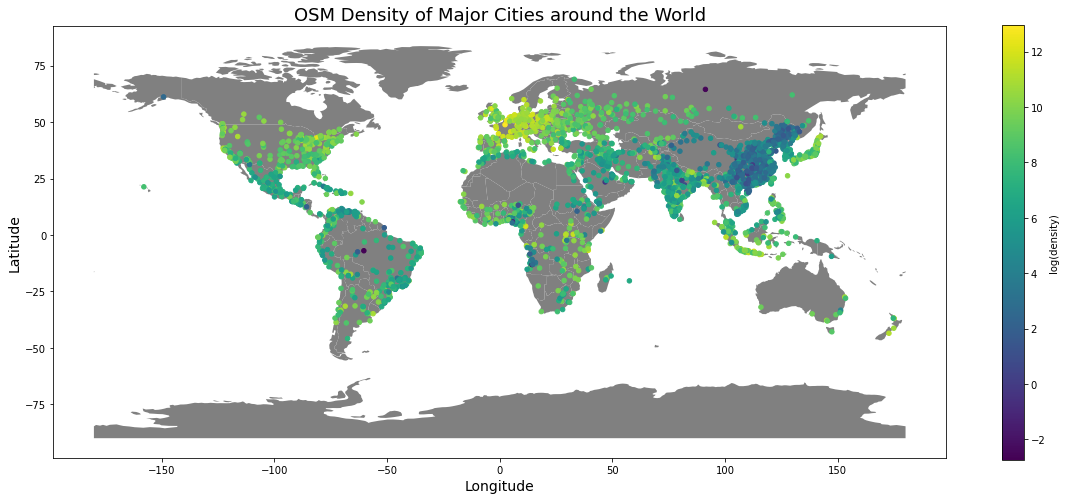

In [19]:
fig, ax = plt.subplots(figsize=(20,8))
countries.plot(color="grey", ax=ax)
cities_df_norm = cities_df.copy()
cities_df_norm["log(density)"] = np.log2(cities_df.loc[:,"density"])
cities_df_norm.plot(x="lng", y="lat", kind="scatter", c="log(density)", ax=ax,
                    colormap="viridis")
ax.set_title("OSM Density of Major Cities around the World", fontsize=18)
ax.set_ylabel("Latitude", fontsize=14)
ax.set_xlabel("Longitude", fontsize=14)
plt.savefig('plots/city_density_global.png', bbox_inches='tight', dpi=150)

Retrieve image and geocode data for selected cities from Europe, Africa and South America.

In [6]:
with open('city_bboxes.json', 'r') as fin:
    city_bboxes = json.load(fin)

In [7]:
os.chdir("C:/Users/Tim/.keras/datasets/greenspace_transfer/ohsome2label")
os.listdir()

['Amsterdam',
 'Asunción',
 'Barranquilla',
 'Bordeaux',
 'Butembo',
 'config_bing.yaml',
 'config_python.yaml',
 'config_template.yaml',
 'Dar es Salaam',
 'Douala',
 'Edinburgh',
 'example_result',
 'Kampala',
 'Lille',
 'Paris',
 'Porto Alegre',
 'Rotterdam',
 'San Juan',
 'schema.yaml',
 'Strasbourg',
 'São Paulo',
 'The Hague',
 'Utrecht',
 'Yaoundé']

In [8]:
city_bboxes

{'London (UK)': [-0.4524994, 51.3559176, 0.1951244, 51.6346407],
 'London (CA)': [-81.3335037, 42.948884, -81.1669922, 43.0320078],
 'Brussels': [4.2784882, 50.8023547, 4.4398499, 50.8795354],
 'Berlin': [13.3023834, 52.4474309, 13.5121536, 52.5707163],
 'Kyoto': [135.6923103, 34.9350598, 135.7752228, 35.0322454],
 'Vienna': [16.3014793, 48.1824554, 16.397953, 48.2340495]}

Write bounding box of each city into `config_template.yaml` and download bing images and OSM vector data.

In [9]:
for city, bbox in city_bboxes.items():
    
    if city in os.listdir():
        print(f"already downloaded data for {city}")
        continue  # already downloaded data for this city
    
    with open("config_template.yaml", 'r') as fin:
        cfg = fin.read()

    cfg = cfg.replace("__NAME__", city)
    cfg = cfg.replace("__BBOX__", str(bbox))

    with open("config_python.yaml", "w") as fout:
        fout.write(cfg)
        
    print(f"\nStarting download for city: {city}")
        
    !ohsome2label --config ./config_python.yaml --schema ./schema.yaml vector
    !ohsome2label --config ./config_python.yaml --schema ./schema.yaml label
    !ohsome2label --config ./config_python.yaml --schema ./schema.yaml image
    !ohsome2label --config ./config_python.yaml --schema ./schema.yaml visualize -n 20


Starting download for city: London (UK)
Download OSM historical data into dir:
C:\Users\Tim\.keras\datasets\greenspace_transfer\ohsome2label\London (UK)\other\raw



100%|##########| 15/15 [03:30<00:00, 14.00s/it]


Tile the OSM data into given zoom level: 16



0it [00:00, ?it/s]
28it [00:00, 256.67it/s]
48it [00:00, 236.07it/s]
75it [00:00, 243.64it/s]
102it [00:00, 250.58it/s]
128it [00:00, 251.43it/s]
157it [00:00, 260.41it/s]
181it [00:00, 249.12it/s]
206it [00:00, 249.32it/s]
237it [00:00, 263.13it/s]
263it [00:01, 248.57it/s]
293it [00:01, 260.96it/s]
324it [00:01, 271.02it/s]
352it [00:01, 251.12it/s]
383it [00:01, 265.89it/s]
411it [00:01, 266.28it/s]
439it [00:01, 270.19it/s]
467it [00:01, 265.60it/s]
496it [00:01, 269.75it/s]
526it [00:02, 276.94it/s]
554it [00:02, 237.46it/s]
585it [00:02, 253.77it/s]
612it [00:02, 244.66it/s]
638it [00:02, 241.37it/s]
667it [00:02, 253.76it/s]
693it [00:02, 251.09it/s]
719it [00:02, 251.43it/s]
745it [00:02, 244.21it/s]
770it [00:03, 225.54it/s]
799it [00:03, 240.70it/s]
827it [00:03, 249.88it/s]
853it [00:03, 239.82it/s]
880it [00:03, 244.57it/s]
905it [00:03, 243.24it/s]
930it [00:03, 235.13it/s]
959it [00:03, 248.26it/s]
985it [00:03, 241.43it/s]
1010it [00:04, 240.36it/s]
1037it [00:04, 243.7

Start download satellite image!



100%|##########| 4461/4461 [12:46<00:00,  5.82it/s]


start visualize 20 pictures!
20
Visualization mode: combined the satellite image with OpenStreetMap features.

Starting download for city: London (CA)
Download OSM historical data into dir:
C:\Users\Tim\.keras\datasets\greenspace_transfer\ohsome2label\London (CA)\other\raw



100%|##########| 15/15 [01:28<00:00,  5.87s/it]


Tile the OSM data into given zoom level: 16



0it [00:00, ?it/s]
25it [00:00, 247.31it/s]
54it [00:00, 258.01it/s]
82it [00:00, 263.34it/s]
102it [00:00, 240.42it/s]
121it [00:00, 217.64it/s]
143it [00:00, 217.97it/s]
166it [00:00, 219.16it/s]
187it [00:00, 209.15it/s]
212it [00:00, 219.02it/s]
234it [00:01, 214.76it/s]
256it [00:01, 213.10it/s]
278it [00:01, 213.92it/s]
306it [00:01, 228.88it/s]
330it [00:01, 227.42it/s]
358it [00:01, 239.07it/s]
385it [00:01, 246.42it/s]
410it [00:01, 243.44it/s]
435it [00:01, 244.23it/s]
460it [00:01, 243.47it/s]
486it [00:02, 246.03it/s]
515it [00:02, 256.66it/s]
544it [00:02, 264.33it/s]
547it [00:02, 239.79it/s]


Start download satellite image!



100%|##########| 547/547 [01:33<00:00,  5.87it/s]


start visualize 20 pictures!
20
Visualization mode: combined the satellite image with OpenStreetMap features.

Starting download for city: Brussels
Download OSM historical data into dir:


100%|##########| 15/15 [02:13<00:00,  8.88s/it]



C:\Users\Tim\.keras\datasets\greenspace_transfer\ohsome2label\Brussels\other\raw
Tile the OSM data into given zoom level: 16


0it [00:00, ?it/s]
25it [00:00, 239.28it/s]
53it [00:00, 247.89it/s]
81it [00:00, 255.03it/s]
109it [00:00, 261.00it/s]
140it [00:00, 273.07it/s]
165it [00:00, 264.80it/s]
190it [00:00, 260.14it/s]
215it [00:00, 246.30it/s]
239it [00:00, 237.42it/s]
264it [00:01, 238.92it/s]
288it [00:01, 232.24it/s]
313it [00:01, 232.60it/s]
337it [00:01, 221.11it/s]
361it [00:01, 225.24it/s]
384it [00:01, 219.56it/s]
406it [00:01, 203.11it/s]
427it [00:01, 197.13it/s]
447it [00:01, 193.06it/s]
470it [00:02, 199.99it/s]
496it [00:02, 213.73it/s]
523it [00:02, 227.07it/s]
547it [00:02, 230.08it/s]
571it [00:02, 226.00it/s]
595it [00:02, 228.37it/s]
619it [00:02, 199.65it/s]
620it [00:02, 227.61it/s]



Start download satellite image!



100%|##########| 620/620 [01:45<00:00,  5.86it/s]


start visualize 20 pictures!
20
Visualization mode: combined the satellite image with OpenStreetMap features.

Starting download for city: Berlin
Download OSM historical data into dir:
C:\Users\Tim\.keras\datasets\greenspace_transfer\ohsome2label\Berlin\other\raw



100%|##########| 15/15 [02:33<00:00, 10.23s/it]


Tile the OSM data into given zoom level: 16



0it [00:00, ?it/s]
22it [00:00, 218.86it/s]
36it [00:00, 186.28it/s]
58it [00:00, 195.15it/s]
73it [00:00, 178.16it/s]
92it [00:00, 180.22it/s]
110it [00:00, 178.09it/s]
129it [00:00, 180.76it/s]
146it [00:00, 172.57it/s]
163it [00:00, 170.17it/s]
181it [00:01, 166.85it/s]
198it [00:01, 150.88it/s]
218it [00:01, 157.29it/s]
234it [00:01, 132.47it/s]
255it [00:01, 148.33it/s]
271it [00:01, 120.73it/s]
292it [00:01, 137.95it/s]
308it [00:01, 127.81it/s]
328it [00:02, 141.89it/s]
344it [00:02, 103.81it/s]
362it [00:02, 118.04it/s]
377it [00:02, 114.56it/s]
397it [00:02, 130.48it/s]
413it [00:02, 125.78it/s]
432it [00:02, 139.82it/s]
448it [00:03, 130.85it/s]
467it [00:03, 136.00it/s]
483it [00:03, 139.89it/s]
498it [00:03, 133.86it/s]
516it [00:03, 143.33it/s]
531it [00:03, 129.66it/s]
551it [00:03, 143.26it/s]
567it [00:03, 144.53it/s]
583it [00:03, 146.62it/s]
602it [00:04, 154.89it/s]
622it [00:04, 165.49it/s]
641it [00:04, 169.64it/s]
659it [00:04, 169.18it/s]
678it [00:04, 174.56it/

Start download satellite image!



100%|##########| 1350/1350 [03:56<00:00,  5.71it/s]


start visualize 20 pictures!
20
Visualization mode: combined the satellite image with OpenStreetMap features.

Starting download for city: Kyoto
Download OSM historical data into dir:
C:\Users\Tim\.keras\datasets\greenspace_transfer\ohsome2label\Kyoto\other\raw



100%|##########| 15/15 [01:11<00:00,  4.79s/it]


Tile the OSM data into given zoom level: 16



0it [00:00, ?it/s]
25it [00:00, 247.92it/s]
52it [00:00, 252.48it/s]
79it [00:00, 254.85it/s]
107it [00:00, 261.71it/s]
143it [00:00, 284.87it/s]
178it [00:00, 299.44it/s]
208it [00:00, 299.55it/s]
237it [00:00, 268.73it/s]
264it [00:00, 238.70it/s]
268it [00:01, 266.32it/s]


Start download satellite image!



100%|##########| 268/268 [00:47<00:00,  5.64it/s]


start visualize 20 pictures!
20
Visualization mode: combined the satellite image with OpenStreetMap features.

Starting download for city: Vienna
Download OSM historical data into dir:
C:\Users\Tim\.keras\datasets\greenspace_transfer\ohsome2label\Vienna\other\raw



100%|##########| 15/15 [02:00<00:00,  8.04s/it]


Tile the OSM data into given zoom level: 16



0it [00:00, ?it/s]
19it [00:00, 175.58it/s]
32it [00:00, 157.13it/s]
46it [00:00, 150.54it/s]
62it [00:00, 153.06it/s]
76it [00:00, 147.74it/s]
90it [00:00, 143.29it/s]
106it [00:00, 146.60it/s]
120it [00:00, 124.18it/s]
133it [00:00, 118.65it/s]
146it [00:01, 117.89it/s]
158it [00:01, 102.02it/s]
169it [00:01, 81.78it/s] 
179it [00:01, 85.99it/s]
193it [00:01, 95.91it/s]
204it [00:01, 98.38it/s]
217it [00:01, 104.48it/s]
231it [00:01, 113.00it/s]
245it [00:02, 119.31it/s]
249it [00:02, 118.09it/s]


Start download satellite image!



100%|##########| 249/249 [00:42<00:00,  5.86it/s]


start visualize 20 pictures!
20
Visualization mode: combined the satellite image with OpenStreetMap features.
